# AuxTel batoid input 200nm per Zk, fit with WEP and CWFS: take 2 

# Simulate auxTel with batoid, compare WEP to CWFS

In [1]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim

We want to simulate specific Zernike perturbations. We use phase screen. 

Wrap that simulation as a function:

In [2]:
def simulate_auxtel_zernikes(seed = 0, z_in = [0,0,0,0,200e-9,0,0,0,0,0,0,0],
                            fname = "auxTel_batoid_zk"):

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
    rng = np.random.default_rng(seed)

    # parameters associated with the observing conditions
    obs_params = {
        # zenith=0 means straight up, while zenith=90 is the horizon
        # greater zenith angle means more atmospheric turbulence
        "zenith": 30 * galsim.degrees,

        # raw_seeing sets how much atmospheric turbulence there is at zenith=0
        # wfsim uses this to calculate how much turbulence there is at 
        # the zenith angle given above
        "raw_seeing": 0.7 * galsim.arcsec,

        # these next three parameters set attributes of the atmosphere, which
        # help determine how much turbulence there is
        "temperature": 293, # Kelvin
        "pressure": 69, # kPa
        "H2O_pressure": 1, # kPa

        # wavelength of the observed light. this is important because light of 
        # longer/shorter wavelength refracts less/more in the atmosphere
        "wavelength": bandpass.effective_wavelength, # nanometers

        # the AuxTel exposure time
        "exptime": 30, # seconds
    }

    # parameters associated with computational aspects of simulating the atmosphere
    atm_params = {
        "screen_size": 819.2,
        "screen_scale": 0.1,
        "nproc": 6,
    }

    # since the wavelength is 622 nm, 
    # +/- 200 nm corresponds to +/- 0.3 waves of perturbation
    #z_in = rng.uniform(-200e-9, 200e-9, size=12)
    
    #z_in = np.zeros(12)
    #z_in[5] = 200e-9
    phase = batoid.Zernike(
        np.array(z_in),
        R_outer=0.6,
        R_inner=0.2115
        
    )
    perturbed = batoid.CompoundOptic(
            (
            batoid.optic.OPDScreen(
                batoid.Plane(),
                phase,
                name='PhaseScreen',
                obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                coordSys=auxtel.stopSurface.coordSys
            ),
            *auxtel.items
        ),
        name='PerturbedAuxTel',
        backDist=auxtel.backDist,
        pupilSize=auxtel.pupilSize,
        inMedium=auxtel.inMedium,
        stopSurface=auxtel.stopSurface,
        sphereRadius=auxtel.sphereRadius,
        pupilObscuration=auxtel.pupilObscuration
    )


    intra = perturbed.withGloballyShiftedOptic("M2", [0, 0, -0.0008])
    extra = perturbed.withGloballyShiftedOptic("M2", [0, 0, +0.0008])

    # start the simulator 
    intra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        intra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )

    extra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        extra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )

    wavelength  =  bandpass.effective_wavelength * 1e-9 # batoid wants meters 
    # the fractional inner radius is 
    # eps = inner_radius / outer_radius = 0.2538 / 0.6 =  0.423 [m]


    # choose a position for the star
    # these angles specify the angle from the optical axis to the star
    thx = np.deg2rad(0)
    thy = np.deg2rad(0)


    zs = batoid.zernike(perturbed, thx, thy, wavelength, eps=0.3525)
    zs*=wavelength  #  waves -> m 
    
    # create a spectrum for the star -- this is needed for chromatic refraction
    # we will randomly select a plausible star temperature, 
    # and calculate the corresponding blackbody spectrum
    star_temp = rng.uniform(4_000, 10_000) # Kelvin
    sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

    # randomly choose a flux (must be an integer)
    flux = 1800000#rng.integers(1_000_000, 2_000_000)

    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)

    print(f'saved {fname}')
    fpath = os.path.join('DM-37533',fname)
    np.savez(fpath,
        intra=intra_simulator.image.array,
        extra=extra_simulator.image.array, 
        zktruth=zs)
    return intra_simulator.image.array, extra_simulator.image.array, zs


Fit with ts_wep:  (`v4.0.0`) lsst_distrib `w2023_02` 

In [ ]:
# for auxtel_a_seed0... I was using eps= 0.423 for zs=batoid .. and in CWFS config
# for auxtel_b_seed. .. I changed eps=0.3525 when reading zs from batoid.zernike, 
# and add R_inner=0.2115 to batoid.Zernike  call
# changed in CWFS config the obscuration from 0.423 to 0.3525  (assuming that )
import time 

seed = 0
N = 12  # that's Z4:Z11 (presumably )
for i in range(N):
    z_in = np.zeros(N)
    z_in[i] = 200e-9
    print(i, z_in)
    t1 = time.time()
    intra_image, extra_image, zk_true = simulate_auxtel_zernikes(seed = seed, z_in = z_in,
                            fname = f"auxtel_b_seed{seed}_image_truth_z{i}")
    t2 = time.time()

    dt = t2-t1 #[seconds]
    print(f'took {dt} seconds\n')
 

0 [2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


saved auxtel_b_seed0_image_truth_z0
took 79.24655103683472 seconds

1 [0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z1
took 92.52699542045593 seconds

2 [0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z2
took 85.8224766254425 seconds

3 [0.e+00 0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z3
took 86.30942440032959 seconds

4 [0.e+00 0.e+00 0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z4
took 108.16897296905518 seconds

5 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z5
took 92.97331094741821 seconds

6 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z6
took 96.67798185348511

Just use `onAxis` given that we have more agreement from the one test.

In [38]:
def cut_stamp(image,xcen=1595,ycen=2000,side=120):
    dx = side
    dy = side
    return image[xcen-dx:xcen+dx, ycen-dy:ycen+dy]


In [51]:
res = {'wep':{}, 'cwfs':{}, 'truth':{}, 'img':{}}
seed =0 
model = 'onAxis'
for i in range(12):
    
    fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz"
    fpath = os.path.join('DM-37533',fname)
    print(fpath)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']
    zk = npz['zktruth']
    
    intra_stamp = cut_stamp(intra_image)#, xcen=595, ycen=1000)
    extra_stamp = cut_stamp(extra_image)#, xcen=595, ycen=1000)
    
    wepZk = fit_ts_wep(intra_stamp, extra_stamp, fieldXY=np.zeros(2), sizeInPix = 240.,
           opticalModel=model)
    res['wep'][i] = wepZk
    
    cwfsZk = fit_cwfs(intra_stamp, extra_stamp, side=120, fieldXY = [0.0, 0.0],
                      opticalModel=model)
    res['cwfs'][i] = cwfsZk
    
    res['truth'][i] = zk
    
    res['img'][i]  = intra_stamp

In [40]:
def compare_zks(cwfsZk,wepZk, zk_true, i, value=200):
    plt.figure()
    plt.plot(np.arange(4,23), wepZk, '-d', label='ts_wep')
    plt.plot(np.arange(4,23), cwfsZk, '-d', label='cwfs')
    plt.plot(np.arange(4,23), zk_true[4:]*1e9,'-d', label='truth')
    plt.xticks(range(4,22)[::2])
    plt.title(f'zk{i}=200[nm]')
    plt.legend()
    plt.xlabel('Zk coefficient')
    plt.ylabel('Zk value [nm]')

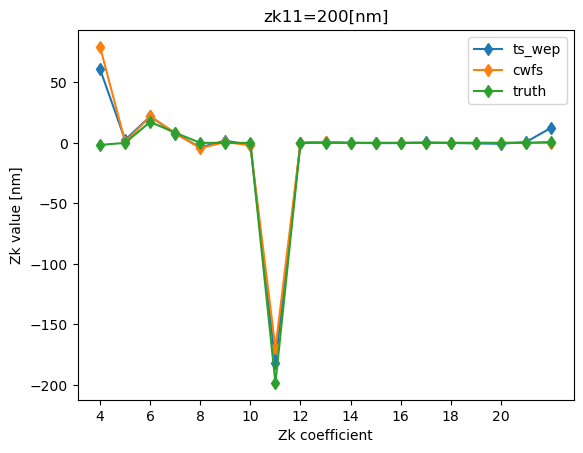

In [53]:
compare_zks(cwfsZk, wepZk, zk_true, i)

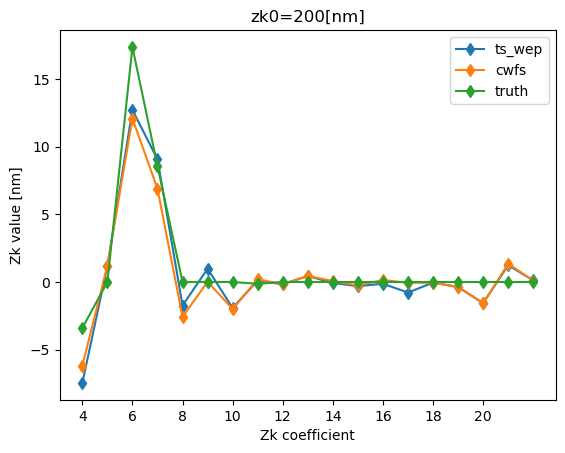

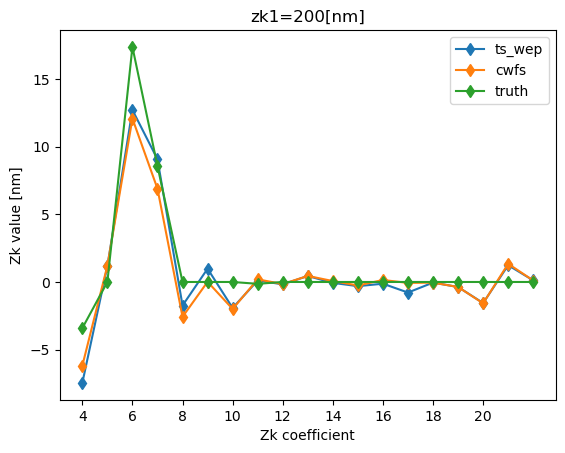

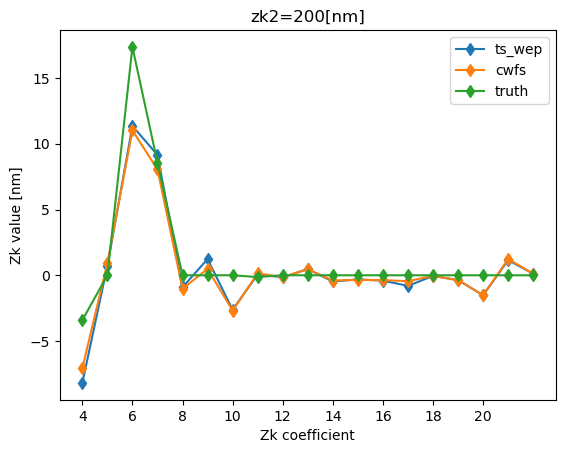

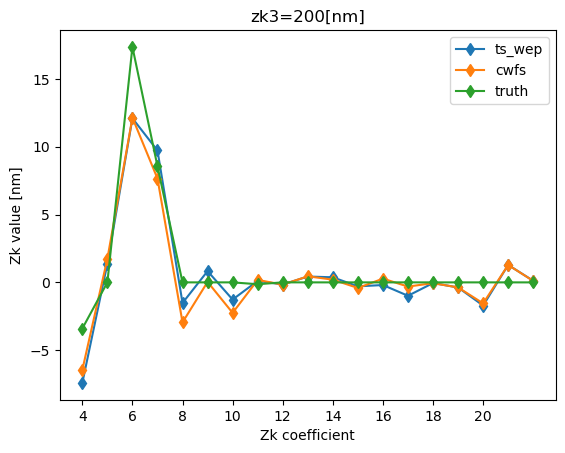

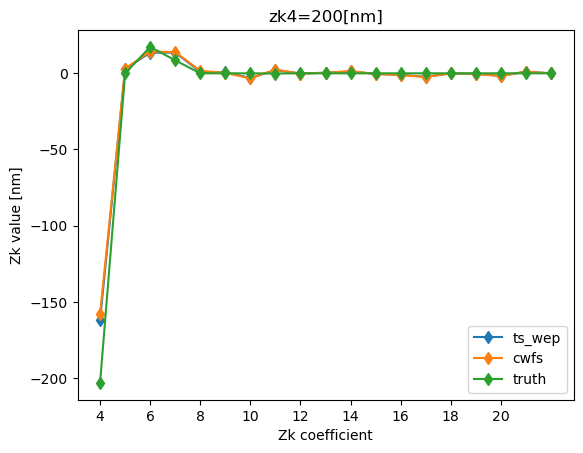

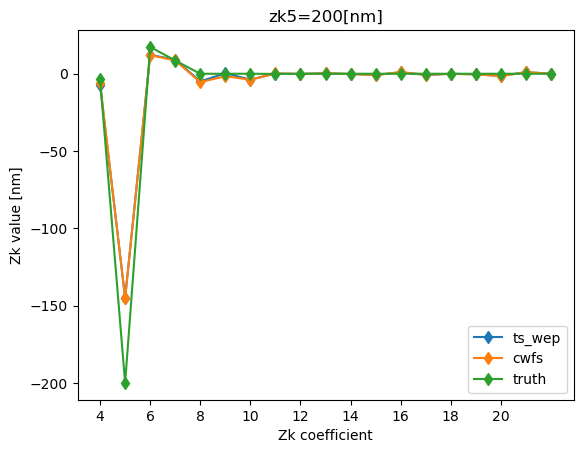

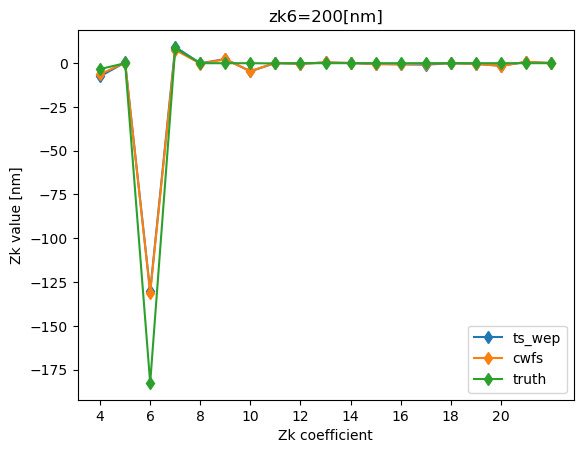

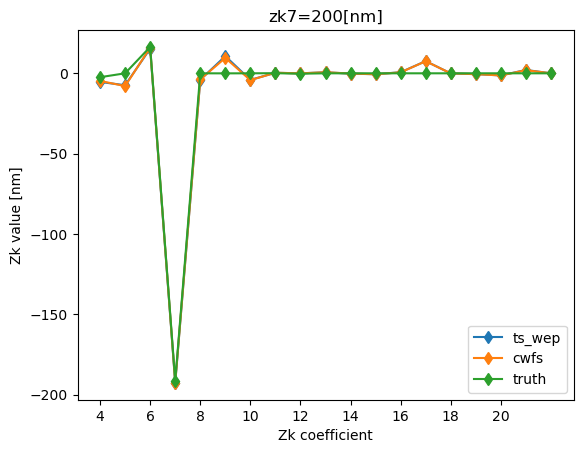

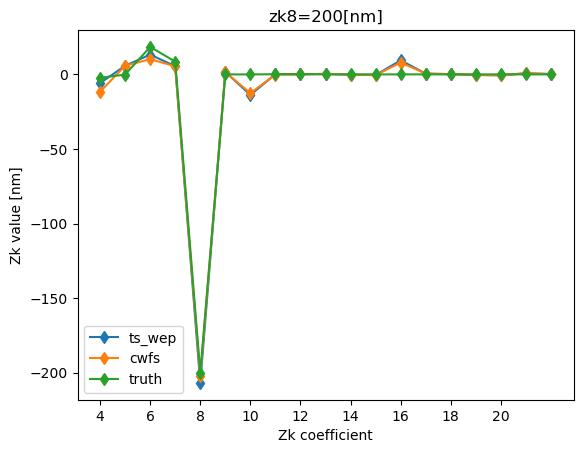

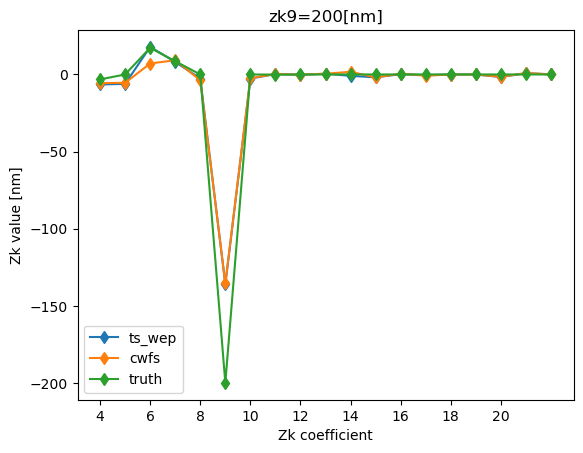

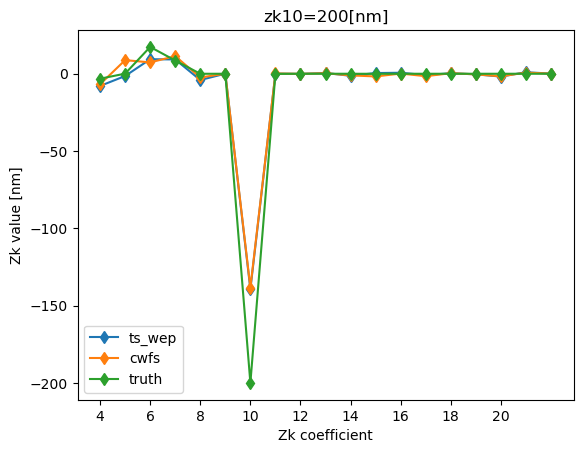

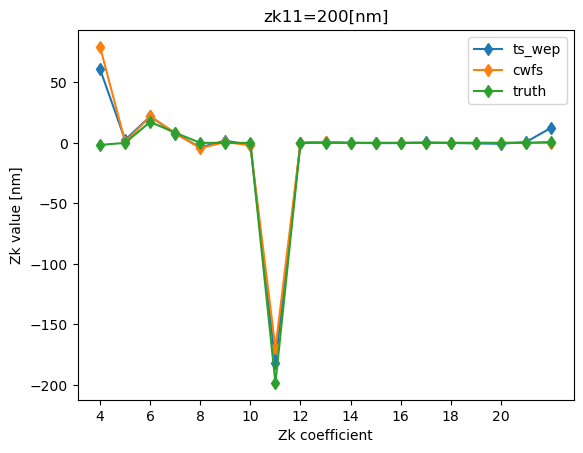

In [55]:
# auxtel_b 
for i in range(12):
        compare_zks(res['cwfs'][i], res['wep'][i], res['truth'][i], i,value=200)
        
        